<a href="https://colab.research.google.com/github/darshan-analytics/CustomerChurnAnalysisUsingSparkETL-KaggleCompetition-/blob/main/CustomerChurnAnalysisUsingSparkETL(KaggleCompetition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [3]:
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz


In [4]:
!tar xf spark-3.0.2-bin-hadoop2.7.tgz


In [5]:
!pip install -q findspark


In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

In [7]:
import findspark
findspark.init()

In [8]:
!pip3 install pyspark

     |████████████████████████████████| 212.3MB 68kB/s 
     |████████████████████████████████| 204kB 16.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=c1e5bfc51c342ba85f94cbfee8a8b5deba906ec1eddbe298d32c226623272e9b
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [9]:
findspark.find()

'/content/spark-3.0.2-bin-hadoop2.7'

In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Spark")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [11]:
spark

In [12]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')

--2021-03-12 04:41:56--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.204.190.140, 52.204.93.39, 52.45.2.52, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.204.190.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  13.9MB/s    in 0.9s    

2021-03-12 04:41:58 (13.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [13]:
!curl -s http://localhost:4040/api/tunnels


{"tunnels":[],"uri":"/api/tunnels"}


In [14]:
!unzip "/content/drive/MyDrive/customer-churn-prediction-2020.zip"


Archive:  /content/drive/MyDrive/customer-churn-prediction-2020.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [15]:
df = spark.read.csv("train.csv", header=True, inferSchema=True)


In [16]:
df.printSchema()

root
 |-- state: string (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: integer (nullable = true)
 |-- churn: string (nullable = true)



In [17]:
df.show()

+-----+--------------+-------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-----+
|state|account_length|    area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churn|
+-----+--------------+-------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+--------

In [18]:
df.describe().show()

+-------+-----+------------------+-------------+------------------+---------------+---------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------------------+-----+
|summary|state|    account_length|    area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|  total_day_calls| total_day_charge| total_eve_minutes|   total_eve_calls|  total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes| total_intl_calls| total_intl_charge|number_customer_service_calls|churn|
+-------+-----+------------------+-------------+------------------+---------------+---------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+--------------

In [19]:
table_name = 'for_churn_analysis'

In [20]:
df.createOrReplaceTempView(table_name)

In [21]:
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql import functions as F
import time

In [22]:
df.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|   no| 3652|
|  yes|  598|
+-----+-----+



In [23]:
df2 = spark.sql("select state, sum(yes) as Churned, sum(no) as Not_churned from (for_churn_analysis) t PIVOT (count(area_code) for churn in ('yes','no')) group by state order by Churned DESC;")

In [24]:
df2.show(5000, truncate= False)

+-----+-------+-----------+
|state|Churned|Not_churned|
+-----+-------+-----------+
|NJ   |26     |70         |
|TX   |19     |79         |
|MN   |19     |89         |
|WV   |19     |120        |
|MD   |19     |67         |
|WA   |18     |62         |
|NV   |17     |66         |
|MT   |17     |63         |
|ME   |16     |73         |
|NY   |16     |80         |
|OK   |16     |62         |
|MI   |15     |72         |
|MS   |15     |67         |
|OR   |15     |84         |
|CT   |15     |73         |
|KS   |15     |72         |
|SC   |14     |58         |
|MA   |14     |75         |
|AL   |13     |88         |
|IN   |13     |70         |
|DE   |13     |67         |
|OH   |12     |83         |
|TN   |12     |67         |
|ID   |12     |94         |
|KY   |12     |73         |
|UT   |12     |85         |
|SD   |11     |64         |
|AR   |11     |60         |
|CA   |10     |29         |
|WY   |10     |85         |
|VT   |10     |76         |
|NH   |10     |68         |
|NM   |10     |68   

In [25]:
df4 = spark.sql("select state, ROUND(Churned *100 / Not_churned, 1) as Churned_percentage from (select state, sum(yes) as Churned, sum(no) as Not_churned from (for_churn_analysis) t PIVOT (count(area_code) for churn in ('yes','no')) group by state) order by Churned_percentage DESC;")

In [26]:
df4.show(5000, truncate= False)

+-----+------------------+
|state|Churned_percentage|
+-----+------------------+
|NJ   |37.1              |
|CA   |34.5              |
|WA   |29.0              |
|MD   |28.4              |
|MT   |27.0              |
|NV   |25.8              |
|OK   |25.8              |
|SC   |24.1              |
|TX   |24.1              |
|MS   |22.4              |
|ME   |21.9              |
|MN   |21.3              |
|MI   |20.8              |
|KS   |20.8              |
|CT   |20.5              |
|NY   |20.0              |
|DE   |19.4              |
|MA   |18.7              |
|IN   |18.6              |
|AR   |18.3              |
|OR   |17.9              |
|TN   |17.9              |
|SD   |17.2              |
|KY   |16.4              |
|WV   |15.8              |
|AL   |14.8              |
|NM   |14.7              |
|NH   |14.7              |
|OH   |14.5              |
|MO   |14.3              |
|UT   |14.1              |
|PA   |13.6              |
|FL   |13.4              |
|VT   |13.2              |
|

In [27]:
df3 = spark.sql("select area_code, ROUND(Churned *100 / Not_churned, 1) as Churned_percentage from (select area_code, sum(yes) as Churned, sum(no) as Not_churned from (for_churn_analysis) t PIVOT (count(state) for churn in ('yes','no')) group by area_code) order by Churned_percentage DESC;")

In [28]:
df3.show(5000, truncate= False)

+-------------+------------------+
|area_code    |Churned_percentage|
+-------------+------------------+
|area_code_510|17.7              |
|area_code_408|16.3              |
|area_code_415|15.8              |
+-------------+------------------+



In [29]:
df5 = spark.sql("select international_plan, ROUND(Churned *100 / Not_churned, 1) as Churned_percentage from (select international_plan, sum(yes) as Churned, sum(no) as Not_churned from (for_churn_analysis) t PIVOT (count(area_code) for churn in ('yes','no')) group by international_plan) order by Churned_percentage DESC;")

In [30]:
df5.show(5000, truncate = True)

+------------------+------------------+
|international_plan|Churned_percentage|
+------------------+------------------+
|               yes|              72.9|
|                no|              12.6|
+------------------+------------------+



In [31]:
df6 = spark.sql("select voice_mail_plan, ROUND(Churned *100 / Not_churned, 1) as Churned_percentage from (select voice_mail_plan, sum(yes) as Churned, sum(no) as Not_churned from (for_churn_analysis) t PIVOT (count(area_code) for churn in ('yes','no')) group by voice_mail_plan) order by Churned_percentage DESC;")

In [32]:
df6.show()

+---------------+------------------+
|voice_mail_plan|Churned_percentage|
+---------------+------------------+
|             no|              19.7|
|            yes|               8.0|
+---------------+------------------+



In [33]:
df7 = spark.sql("select total_day_minutes from for_churn_analysis where churn=('yes');")

In [34]:
df7.show()

+-----------------+
|total_day_minutes|
+-----------------+
|            129.1|
|            332.9|
|             62.4|
|            249.6|
|            173.1|
|            198.4|
|            178.9|
|            300.3|
|             61.6|
|            157.9|
|            237.9|
|            203.4|
|            212.1|
|            251.8|
|            196.8|
|            282.5|
|             70.7|
|            187.5|
|            167.1|
|            337.4|
+-----------------+
only showing top 20 rows



In [35]:
df8 = spark.sql("select total_day_minutes from for_churn_analysis where churn=('no');")

In [36]:
df8.show()

+-----------------+
|total_day_minutes|
+-----------------+
|            161.6|
|            243.4|
|            299.4|
|            166.7|
|            218.2|
|            157.0|
|            184.5|
|            258.6|
|            187.7|
|            128.8|
|            156.6|
|            196.4|
|            189.7|
|            224.4|
|            155.1|
|            183.0|
|            110.4|
|             81.1|
|            213.0|
|            134.3|
+-----------------+
only showing top 20 rows



In [37]:
df10 = df7.toPandas()

In [38]:
df11 = df8.toPandas()

In [39]:
import matplotlib.pyplot as plt


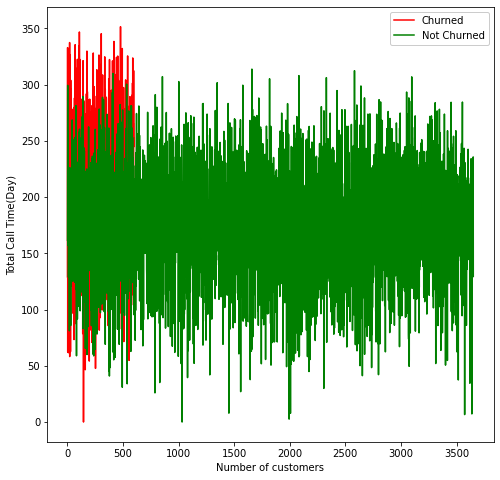

In [40]:
plt.figure(figsize=(8,8))
plt.plot(df10, label= 'Churned', color= 'red')
plt.plot(df11, label='Not Churned', color='green')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Number of customers')
plt.ylabel('Total Call Time(Day)')

plt.show()

In [41]:
dataset = df.toPandas()

In [42]:
dataset

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,no
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,no
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,no
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,no


In [43]:
dataset.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [44]:
df.stat.freqItems(['state','area_code','international_plan','voice_mail_plan'],0.7).collect()

[Row(state_freqItems=[], area_code_freqItems=['area_code_415'], international_plan_freqItems=['no'], voice_mail_plan_freqItems=['no'])]

In [45]:
df12 = spark.sql("select number_customer_service_calls from for_churn_analysis where churn=('yes');")

In [46]:
df12.show(200)

+-----------------------------+
|number_customer_service_calls|
+-----------------------------+
|                            4|
|                            4|
|                            5|
|                            1|
|                            0|
|                            3|
|                            4|
|                            0|
|                            4|
|                            4|
|                            1|
|                            0|
|                            1|
|                            2|
|                            0|
|                            1|
|                            4|
|                            4|
|                            2|
|                            0|
|                            5|
|                            2|
|                            4|
|                            0|
|                            5|
|                            2|
|                            4|
|                            1|
|       

In [47]:
df13 = spark.sql("select number_customer_service_calls from for_churn_analysis where churn=('no');")

In [48]:
df13.show(200)

+-----------------------------+
|number_customer_service_calls|
+-----------------------------+
|                            1|
|                            0|
|                            2|
|                            3|
|                            3|
|                            0|
|                            1|
|                            0|
|                            0|
|                            1|
|                            3|
|                            1|
|                            1|
|                            1|
|                            0|
|                            0|
|                            2|
|                            0|
|                            0|
|                            3|
|                            0|
|                            1|
|                            1|
|                            0|
|                            0|
|                            1|
|                            3|
|                            3|
|       

In [49]:
df14 = df12.toPandas()
df15 = df13.toPandas()

In [50]:
df14

,number_customer_service_calls
0,4
1,4
2,5
3,1
4,0
...,...
593,2
594,4
595,1
596,1


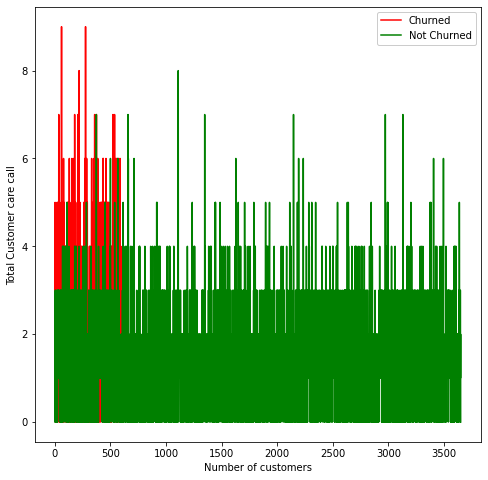

In [51]:
plt.figure(figsize=(8,8))
plt.plot(df14, label= 'Churned', color= 'red')
plt.plot(df15, label='Not Churned', color='green')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Number of customers')
plt.ylabel('Total Customer care call')

plt.show()

In [52]:
df15  =  spark.sql("select total_day_charge from for_churn_analysis where churn=('yes');")

In [53]:
df16 =  spark.sql("select total_day_charge from for_churn_analysis where churn=('no');")

In [54]:
df17 = df15.toPandas()
df18 = df16.toPandas()

In [55]:
type(df18)

pandas.core.frame.DataFrame

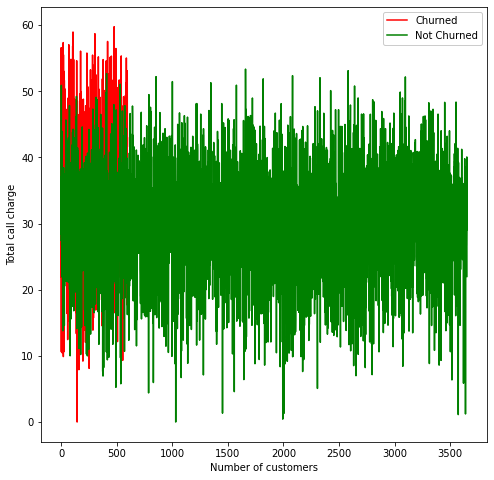

In [56]:
plt.figure(figsize=(8,8))
plt.plot(df17, label= 'Churned', color= 'red')
plt.plot(df18, label='Not Churned', color='green')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Number of customers')
plt.ylabel('Total call charge')

plt.show()

In [57]:
data = df

In [58]:
###No need to add imputer stage as there isn't any missing value in the dataset

In [59]:
(train_data, test_data) = data.randomSplit([0.7,0.3],24)

In [60]:
print(train_data.count())

2969


In [61]:
print(test_data.count())

1281


In [62]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [63]:
cat = ["state","area_code","international_plan","voice_mail_plan"]

In [64]:
stage_in_pipeline = []
for each_cat in cat:
  stringIndexer = StringIndexer(inputCol= each_cat, outputCol= each_cat + "Index")
  encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols= [each_cat + "cat_col"])
#  encoder = OneHotEncoder(inputCol=each_cat+ "Index", outputCol= each_cat + "cat_col")
  stage_in_pipeline += [stringIndexer, encoder]

In [65]:
output_label = StringIndexer(inputCol="churn", outputCol="label")
stage_in_pipeline += [output_label]

In [66]:
stage_in_pipeline

[StringIndexer_55e39c598cad,
 OneHotEncoder_0c6d86dc9b43,
 StringIndexer_847122a872f8,
 OneHotEncoder_76b20868a268,
 StringIndexer_46a442869be0,
 OneHotEncoder_3970de56a112,
 StringIndexer_d643431d4878,
 OneHotEncoder_2c77ebc36320,
 StringIndexer_f43b927816a9]

In [67]:
import seaborn as sns

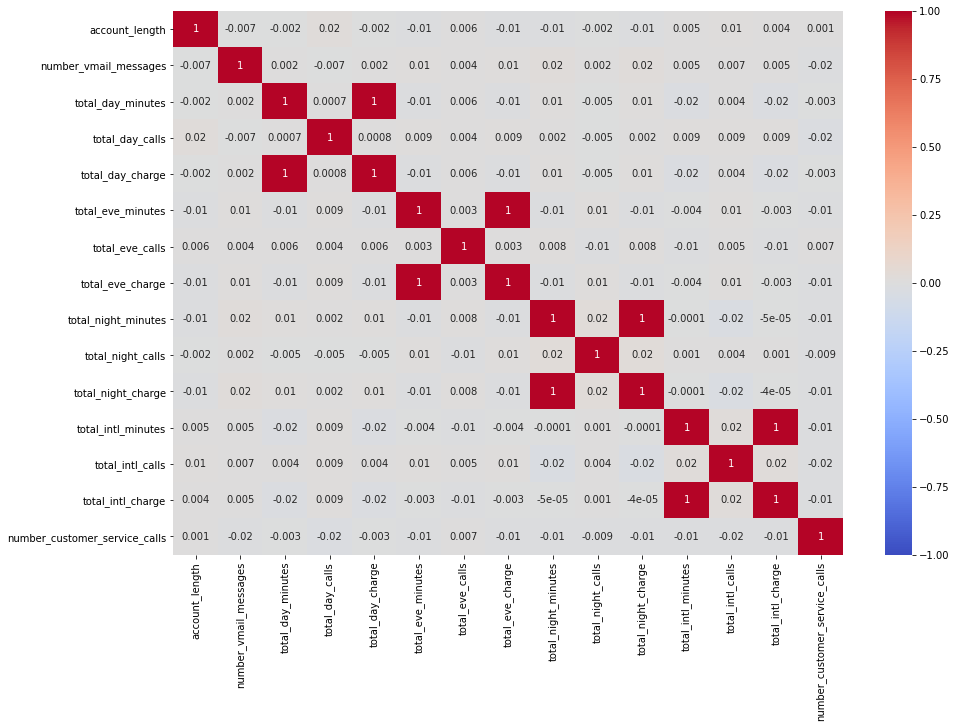

In [68]:
plt.figure(figsize=(15,10))
sns.heatmap(dataset.corr(), annot=True, fmt= '.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [69]:
from pyspark.ml.feature import QuantileDiscretizer

In [70]:
bins = QuantileDiscretizer(numBuckets=4, inputCol="account_length", outputCol="bins")
stage_in_pipeline += [bins]

In [71]:
###dropping one column from the highly correlated attributes

In [72]:
nr_columns = ["bins","number_vmail_messages", "total_day_charge","total_eve_charge","total_night_charge","total_intl_charge","total_day_minutes","total_day_calls","total_eve_minutes","total_eve_calls","total_night_minutes","total_night_calls","total_intl_minutes","total_intl_calls","number_customer_service_calls"]

In [73]:
assemble_ip = assemblerInput = [c + "cat_col" for c in cat] + nr_columns

In [74]:
assembler = VectorAssembler(inputCols= assemble_ip, outputCol="features")

In [75]:
stage_in_pipeline += [assembler]

In [76]:
stage_in_pipeline

[StringIndexer_55e39c598cad,
 OneHotEncoder_0c6d86dc9b43,
 StringIndexer_847122a872f8,
 OneHotEncoder_76b20868a268,
 StringIndexer_46a442869be0,
 OneHotEncoder_3970de56a112,
 StringIndexer_d643431d4878,
 OneHotEncoder_2c77ebc36320,
 StringIndexer_f43b927816a9,
 QuantileDiscretizer_709a00a2626b,
 VectorAssembler_ebcd0e1bdd35]

In [77]:
pipeline = Pipeline(stages=stage_in_pipeline)

In [78]:
pipeline_model = pipeline.fit(train_data)

In [79]:
trained_data = pipeline_model.transform(train_data)
testing_data = pipeline_model.transform(test_data)

In [80]:
from pyspark.ml.classification import LogisticRegression
logistic = LogisticRegression(labelCol ='label', featuresCol = 'features', maxIter = 10 )
logitstic_model = logistic.fit(trained_data)
model_trained = logitstic_model.transform(trained_data)

In [81]:
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
y_train = model_trained.select(['label']).collect()
y_pred = model_trained.select(['prediction']).collect()
print(classification_report(y_true= y_train, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93      2528
         1.0       0.62      0.29      0.40       441

    accuracy                           0.87      2969
   macro avg       0.76      0.63      0.66      2969
weighted avg       0.85      0.87      0.85      2969



In [82]:
####apply other models and do the evaluation set after which will deploy model

In [83]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=10,featuresCol='features', labelCol='label')
lsvcModel = lsvc.fit(trained_data)
lsvctrainedmodel = lsvcModel.transform(trained_data)

In [84]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [85]:
y_train2 = lsvctrainedmodel.select(['label']).collect()
y_pred2 = lsvctrainedmodel.select(['prediction']).collect()
print(classification_report(y_true= y_train2, y_pred=y_pred2 ))

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      2528
         1.0       0.00      0.00      0.00       441

    accuracy                           0.85      2969
   macro avg       0.43      0.50      0.46      2969
weighted avg       0.72      0.85      0.78      2969



In [86]:
from pyspark.ml.classification import GBTClassifier

GBT = GBTClassifier(maxIter=10,featuresCol='features', labelCol='label')
GBTMODEL = GBT.fit(trained_data)
GBTMODELTrain = GBTMODEL.transform(trained_data)

In [87]:
y_train2 = GBTMODELTrain.select(['label']).collect()
y_pred2 = GBTMODELTrain.select(['prediction']).collect()
print(classification_report(y_true= y_train2, y_pred=y_pred2 ))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      2528
         1.0       0.97      0.77      0.86       441

    accuracy                           0.96      2969
   macro avg       0.96      0.88      0.92      2969
weighted avg       0.96      0.96      0.96      2969



In [88]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [89]:
predictions = GBTMODEL.transform(testing_data)
predictions.select('state','international_plan','voice_mail_plan', 'label', 'rawPrediction', 'prediction', 'probability').show(100000, truncate= False)

+-----+------------------+---------------+-----+----------------------------------------------+----------+-----------------------------------------+
|state|international_plan|voice_mail_plan|label|rawPrediction                                 |prediction|probability                              |
+-----+------------------+---------------+-----+----------------------------------------------+----------+-----------------------------------------+
|AK   |no                |no             |0.0  |[1.2636837401584249,-1.2636837401584249]      |0.0       |[0.9260382505140908,0.07396174948590917] |
|AK   |no                |yes            |0.0  |[1.2244156931991443,-1.2244156931991443]      |0.0       |[0.9204759503518146,0.07952404964818538] |
|AK   |no                |yes            |0.0  |[1.0828288326928197,-1.0828288326928197]      |0.0       |[0.897122888219732,0.10287711178026804]  |
|AK   |no                |no             |0.0  |[1.2059499696902944,-1.2059499696902944]      |0.0       |

In [90]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9120095428066283


In [91]:
df_test = spark.read.csv("test.csv", header=True, inferSchema=True)
testing = pipeline_model.transform(df_test)
predictions = GBTMODEL.transform(testing)
df_sub = predictions.select('prediction')
df_sub = df_sub.toPandas()
df_sub['prediction'] = df_sub['prediction'].map({0:'no', 1:'yes'})
df_sub = df_sub.rename(columns={'prediction':'churn'})
df_sub.index += 1
df_sub.to_csv('submission.csv', index_label='ID')


In [92]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(GBT.maxDepth, [2, 4, 6])
             .addGrid(GBT.maxBins, [20, 60])
             .addGrid(GBT.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=GBT, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(trained_data)
predictions = cvModel.transform(testing_data)
evaluator.evaluate(predictions)

0.9152112564317599

In [93]:
from pyspark.ml.classification import DecisionTreeClassifier

linearreg = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=5)
linearregModel = linearreg.fit(trained_data)
trainedlinear = linearregModel.transform(trained_data)

In [94]:
y_train2 = trainedlinear.select(['label']).collect()
y_pred2 = trainedlinear.select(['prediction']).collect()
print(classification_report(y_true= y_train2, y_pred=y_pred2 ))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2528
         1.0       0.95      0.71      0.82       441

    accuracy                           0.95      2969
   macro avg       0.95      0.85      0.89      2969
weighted avg       0.95      0.95      0.95      2969



In [95]:
####add model into pipeline then make kubernetus to deploy app


In [96]:
from pyspark.ml.classification import GBTClassifier

GBT = GBTClassifier(maxIter=10,featuresCol='features', labelCol='label')
stage_in_pipeline += [GBT]

In [97]:
pipeline = Pipeline(stages=stage_in_pipeline)
pipeline_model = pipeline.fit(train_data)
pipeline_train = pipeline_model.transform(train_data)

In [98]:
y_train5 = pipeline_train.select(['label']).collect()
y_pred5 = pipeline_train.select(['prediction']).collect()
print(classification_report(y_true= y_train5, y_pred=y_pred5 ))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      2528
         1.0       0.97      0.77      0.86       441

    accuracy                           0.96      2969
   macro avg       0.96      0.88      0.92      2969
weighted avg       0.96      0.96      0.96      2969



In [99]:
predict = pipeline_model.transform(test_data)
predict.select('state','international_plan','voice_mail_plan', 'label', 'rawPrediction', 'prediction', 'probability').show(100000, truncate= False)

+-----+------------------+---------------+-----+----------------------------------------------+----------+-----------------------------------------+
|state|international_plan|voice_mail_plan|label|rawPrediction                                 |prediction|probability                              |
+-----+------------------+---------------+-----+----------------------------------------------+----------+-----------------------------------------+
|AK   |no                |no             |0.0  |[1.2636837401584249,-1.2636837401584249]      |0.0       |[0.9260382505140908,0.07396174948590917] |
|AK   |no                |yes            |0.0  |[1.2244156931991443,-1.2244156931991443]      |0.0       |[0.9204759503518146,0.07952404964818538] |
|AK   |no                |yes            |0.0  |[1.0828288326928197,-1.0828288326928197]      |0.0       |[0.897122888219732,0.10287711178026804]  |
|AK   |no                |no             |0.0  |[1.2059499696902944,-1.2059499696902944]      |0.0       |

In [100]:
y_train6 = predict.select(['label']).collect()
y_pred6 = predict.select(['prediction']).collect()
print(classification_report(y_true= y_train6, y_pred=y_pred6 ))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      1124
         1.0       0.78      0.66      0.71       157

    accuracy                           0.94      1281
   macro avg       0.87      0.82      0.84      1281
weighted avg       0.93      0.94      0.93      1281



In [101]:
predict = pipeline_model.transform(df_test)
predict.select('prediction').show(100000, truncate= False)

+----------+
|prediction|
+----------+
|0.0       |
|0.0       |
|1.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|1.0       |
|1.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|1.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|1.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|1.0       |
|0.0       |
|0.0       |
|0.0       |
|1.0       |
|0.0       |
|0.0       |
|0.0       |
|1.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|0.0       |
|1.0       |
|0.0       |
|0.0       |

In [102]:
import pickle

In [103]:
from pyspark.ml import PipelineModel
pipeline_model2 = PipelineModel.load("/content/drive/MyDrive/Colab Notebooks/my_model")

In [104]:
df_test  = df_test.toPandas()
df_test

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,746,GA,130,area_code_415,no,no,0,119.4,99,20.30,226.3,97,19.24,202.7,111,9.12,11.3,7,3.05,0
746,747,WA,73,area_code_408,no,no,0,177.2,118,30.12,270.5,84,22.99,241.8,112,10.88,12.3,2,3.32,3
747,748,WV,152,area_code_415,no,no,0,184.2,90,31.31,256.8,73,21.83,213.6,113,9.61,14.7,2,3.97,3
748,749,DC,61,area_code_415,no,no,0,140.6,89,23.90,172.8,128,14.69,212.4,97,9.56,13.6,4,3.67,1


In [105]:
df_check = df_test

In [106]:
df_check  = spark.sql("select * from for_churn_analysis limit 1")

In [107]:
from pyspark.sql import SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [108]:
c = sqlContext.createDataFrame(df_test.iloc[[1]])
print(df_test.iloc[[1]])
p = pipeline_model2.transform(c)
p.select('prediction').show(10)

   id state  ...  total_intl_charge number_customer_service_calls
1   2    AL  ...                1.7                             0

[1 rows x 20 columns]
+----------+
|prediction|
+----------+
|       0.0|
+----------+



In [151]:
def predict_data(df_in):
  save = pipeline_model2.transform(df_in)
  data = save.select('prediction')
  data_to_send = data.toPandas()
  for i in data_to_send['prediction']:
    if i == 0.0:
      return 'Customer will not churn'
    else:
      return 'Customer will churn'
  


In [110]:
!pip install flask-ngrok


In [150]:
'''check  = predict_data(c)
print(check)
for i in check['prediction'].iteritems():
  if i == 0.0:
    print('got it')

for i in check['prediction']:
  if i == 0.0:
    print('Hurray')'''

   prediction
0         0.0
Hurray


In [113]:
from pyspark.sql.functions import col

In [153]:
from flask import Flask,request, url_for, redirect, render_template, jsonify
from flask_ngrok import run_with_ngrok
import numpy as np
import pandas as pd


cols = ['state', 'account_length',	'area_code',	'international_plan',	'voice_mail_plan',	'number_vmail_messages',	'total_day_minutes',	'total_day_calls',	'total_day_charge',	'total_eve_minutes',	'total_eve_calls',	'total_eve_charge', 'total_night_minutes',	'total_night_calls',	'total_night_charge',	'total_intl_minutes',	'total_intl_calls',	'total_intl_charge',	'number_customer_service_calls']


app = Flask(__name__, template_folder='/content/drive/MyDrive/Colab Notebooks/templates',static_folder='/content/drive/MyDrive/Colab Notebooks/static')
run_with_ngrok(app)


@app.route('/')
def home():
    return render_template("home.html")

@app.route('/predict',methods=['POST'])
def predict():
    int_features = [x for x in request.form.values()]
    print(int_features)
    final = np.array(int_features)
    column = np.array(cols)
    
    data_unseen = pd.DataFrame([final], columns = cols)
    #sent = data_c(data_unseen)
    print(data_unseen)
    print(type(data_unseen))
    data = sqlContext.createDataFrame([int_features]).toDF('state', 'account_length',	'area_code',	'international_plan',	'voice_mail_plan',	'number_vmail_messages',	'total_day_minutes',	'total_day_calls',	'total_day_charge',	'total_eve_minutes',	'total_eve_calls',	'total_eve_charge', 'total_night_minutes',	'total_night_calls',	'total_night_charge',	'total_intl_minutes',	'total_intl_calls',	'total_intl_charge',	'number_customer_service_calls')
    data = data.withColumn('account_length', col('account_length').cast('int'))
    data = data.withColumn('number_vmail_messages', col('number_vmail_messages').cast('int'))
    data = data.withColumn('total_day_minutes', col('total_day_minutes').cast('double'))
    data = data.withColumn('total_day_calls', col('total_day_calls').cast('int'))
    data = data.withColumn('total_day_charge', col('total_day_charge').cast('double'))
    data = data.withColumn('total_eve_minutes', col('total_eve_minutes').cast('double'))
    data = data.withColumn('total_eve_calls', col('total_eve_calls').cast('int'))
    data = data.withColumn('total_eve_charge', col('total_eve_charge').cast('double'))
    data = data.withColumn('total_night_minutes', col('total_night_minutes').cast('double'))
    data = data.withColumn('total_night_calls', col('total_night_calls').cast('int'))
    data = data.withColumn('total_night_charge', col('total_night_charge').cast('double'))
    data = data.withColumn('total_intl_minutes', col('total_intl_minutes').cast('double'))
    data = data.withColumn('total_intl_calls', col('total_intl_calls').cast('int'))
    data = data.withColumn('total_intl_charge', col('total_intl_charge').cast('double'))
    data = data.withColumn('number_customer_service_calls', col('number_customer_service_calls').cast('int'))


    data.show(1)
    
    data.printSchema()
    prediction = predict_data(data)
    print(prediction)


    #prediction = predict_model(model, data=data_unseen, round = 0)
    #prediction = int(prediction.Label[0])
    #prediction = ' test'
    return render_template('home.html',pred='The Prediction is {}'.format(prediction))

@app.route('/predict_api',methods=['POST'])
def predict_api():
    #data = request.get_json(force=True)
    #data_unseen = pd.DataFrame([data])
    #prediction = predict_model(model, data=data_unseen)
    #output = prediction.Label[0]
    output = [1,2,3]
    return jsonify(output)

if __name__ == '__main__':
  app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
